# Kreiranje _dataset_-a
U ovom fajlu je prikazan način na koji smo, uz pomoć _web-scrapinga_-a, dobavili sve željene parfeme i popunili svoj _dataset_. Kao primer, uzećemo prvu stranicu iz parfimerije _Jasmin_, kako bismo prikazali implementirani _scraping_. Sa ove stranice možemo preuzeti podatke poput brenda, naziva parfema i slike parfema, za ostale podatke ćemo kasnije koristiti _fragrantica.com_ sajt kako bismo upotpunili _dataset_.

_Scraping_ je implementiran uz pomoć biblioteka poput _requests_, _BeautifulSoup_ i _Selenium_.

## _Scraping_ Jasmina

In [52]:
import requests
import bs4
from selenium import webdriver
import csv
import re
import random
import time


HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36'
}

female_fragrances_urls = [
    'https://www.jasmin.rs/zenski-parfemi/parfemi-i-toaletne-vode.html#206=94563',
]

`scrape_fragrances()` funckija prolazi kroz prosleđenu listu _URL_-ova (u ovom slučaju to je samo jedan _URL_), šalje _HTTP_ zahteve za svaku stranicu, parsira _HTML_ sadržaj i izdvaja podatke o parfemima (brend, naziv, slika). Dobijene podatke upisuje u _CSV_ fajl. Funkcija je namenjena automatskom prikupljanju podataka o parfemima sa web stranica.

In [41]:
def scrape_fragrances(urls, gender, csv_writer):
    page_num = 1
    for url in urls:
        print(f'Scraping {gender} fragrances - Page {page_num}')
        try:
            response = requests.get(url, headers=HEADERS)
            response.raise_for_status()
        except requests.RequestException as e:
            print(f'Failed to fetch data from {url}: {e}')
            continue

        soup = bs4.BeautifulSoup(response.text, 'html.parser')

        ol_tag = soup.find('ol', class_='products list items product-items')
        if not ol_tag:
            print(f"No products found on page {page_num} for {gender} fragrances.")
            continue

        li_tags = ol_tag.find_all('li')

        for li in li_tags:
            img_tag = li.find('img', class_='product-image-photo')
            img_src = img_tag['src'] if img_tag else 'No image'
            div_tag = li.find('div', class_='product details product-item-details')
            brand_name = div_tag.find('span',
                                      class_='product-item-brand').get_text().strip() if div_tag else 'Unknown Brand'
            strong_tag = div_tag.find('strong', class_='product name product-item-name') if div_tag else None
            item_name = strong_tag.find('a',
                                        class_='product-item-link').get_text().strip() if strong_tag else 'Unknown Item'

            csv_writer.writerow([brand_name, item_name, img_src])

        page_num += 1

Pokretanje same _scraping_ funkcije je opisano u nastavku. Otvara se, privremeno kreirani, `jasminNotebookResults.csv` fajl, upisuje se prvi red koji sadrži atribute poput brenda, naziva parfema i _URL_ slike. Poziva se prethodno opisana funkcija `scrape_fragrances()` i rezultati se upisuju u `jasminNotebookResults.csv` fajl, koji će kasnije biti korišćen za dobavljanje dodatnih podataka o dobavljenim parfemima.

In [42]:
print('Starting to scrape fragrances and write to CSV...')

with open('jasminNotebookResults.csv', mode='w', newline='', encoding='utf-8') as file:
    csv_writer = csv.writer(file)

    csv_writer.writerow(['Brand', 'Name', 'Image URL'])

    scrape_fragrances(female_fragrances_urls, 'female', csv_writer)

print('Done scraping fragrances and writing to CSV!')

Starting to scrape fragrances and write to CSV...
Scraping female fragrances - Page 1
Done scraping fragrances and writing to CSV!


Primer jednog reda rezultata u `jasminNotebookResults.csv` fajlu:

## Uklanjanje duplikata i neželjenih proizvoda

S obzirom na to da prikupljamo parfeme sa različitih sajtova poput Jasmina, Sefore i Metropolitena, očigledno je da postoji mogućnost da se pojave duplikati među parfemima. Kako bismo smatrali naš skup podataka verodostojnim, odlučili smo se da uklonimo sve moguće duplikate.

Osim duplikata, pojavljuju se i proizvodi koji nama nisu od interesa za ovaj projekat, poput _set_, _candle_, _refill_, _mist_, itd. Mi smo odabrali da se isključivo fokusiramo na parfeme. Ostali proizvodi se dobavljaju jer prosto stranice određenih sajtova nemaju mogućnost da se rezultati pretrage filtriraju samo na parfeme.

Mehanizam uklanjanja je implementiran unutar `remove_duplicates()` funckije.

Kreira se skup `seen` za praćenje već obrađenih (brend, naziv) kombinacija i skup `exclude_keywords` sa rečima koje označavaju proizvode koje treba izostaviti (npr. "_refill_", "_set_", "_candle_", "_mist_", itd.).

Otvara se ulazni _CSV_ fajl za čitanje i izlazni _CSV_ fajl za pisanje, oba sa _UTF-8_ enkodiranjem.

Prvi red (zaglavlje) se kopira iz ulaznog u izlazni fajl.

Za svaki red iz ulaznog fajla se izdvajaju brend i naziv parfema. Potom, naziv se pretvara u mala slova radi lakšeg poređenja.

Proizvod se upisuje u izlazni fajl samo ako se kombinacija (brend, naziv) već ne nalazi u izlaznom fajlu (nema duplikata) i samo ukoliko naziv ne sadrži nijednu od isključujućih ključnih reči (npr. "_set_", "_mist_", "_oil_").

In [50]:
import csv


def remove_duplicates(input_file, output_file):
    seen = set()
    exclude_keywords = {
        'refill', 'set', 'travel spray', 'candle', 'rollerball', 'mist', 'deodorant', 'oil', 'lotion'
    }

    with open(input_file, mode='r', newline='', encoding='utf-8') as infile, \
            open(output_file, mode='w', newline='', encoding='utf-8') as outfile:

        reader = csv.reader(infile)
        writer = csv.writer(outfile)

        header = next(reader)
        writer.writerow(header)

        for row in reader:
            brand, name = row[0], row[1]
            lower_name = name.lower()

            if (brand, name) not in seen and not any(keyword in lower_name for keyword in exclude_keywords):
                writer.writerow(row)
                seen.add((brand, name))
            else:
                print(f'Skipping duplicate or excluded item - Brand: {brand}, Name: {name}')

# Treba samo ručno podesiti ulazni i izlazni fajl
if __name__ == "__main__":
    input_csv = 'jasminNotebookResults.csv'
    output_csv = 'jasminNotebookUniqueResults.csv'

    remove_duplicates(input_csv, output_csv)
    print('Duplicate rows removed and saved to', output_csv)


Skipping duplicate or excluded item - Brand: Salvatore Ferragamo, Name: Signorina Misteriosa Woman Edp
Duplicate rows removed and saved to jasminNotebookUniqueResults.csv


## Dobavljanje URL-ova sa fragrantica-e

Uspeli smo da dobavimo brend, naziv i _URL_ slike parfema, ali kako bismo uspeli da dobavimo ostale neophodne podatke, moramo na neki način doći do _URL_-a na _fragrantica_ sajtu za svaki od naših parfema u _dataset_-u.

Pokreće se _Firefox WebDriver_, koji otvara zadatu stranicu _fragrantica_ za određeni brend (u ovom slučaju Carolina Herrera).
Ovo je neophodno jer _fragrantica_ dinamički generiše sadržaj, pa običan _HTTP_ zahtev ne bi vratio sve podatke.

`driver.implicitly_wait(2)` omogućava da se sačeka da se svi elementi stranice učitaju pre nastavka.

Preuzima se kompletan _HTML_ sadržaj stranice (`driver.page_source`) i prosleđuje _BeautifulSoup_ parseru.

Kroz niz `find` i `find_all` metoda, kod pronalazi deo stranice gde su prikazani parfemi.

Prvo se pronalazi glavni kontejner (`div` sa klasom `off-canvas-content content1 has-reveal-left`). Zatim se ide dublje kroz hijerarhiju `div`-ova dok se ne dođe do liste parfema (`ais-InfiniteHits`).

Pronalaze se svi `<a>` tagovi unutar odgovarajućeg dela stranice. Svaki `<a>` tag sadrži link ka stranici pojedinačnog parfema.

Otvara se fajl `fragranticaUrlOnly.csv` za pisanje, gde se Prvo upisuje zaglavlje (_Fragrance URL_). Zatim se za svaki pronađeni `<a>` tag izdvajaju vrednosti atributa `href` (_URL_ parfema) i upisuju u fajl.

Na samom kraju, zatvara se _Firefox Webdriver_ uz pomoc `driver.quit()`.

In [ ]:
import bs4
import csv
from selenium import webdriver

driver = webdriver.Firefox()
driver.get('https://www.fragrantica.com/search/?dizajner=Carolina%20Herrera')

driver.implicitly_wait(2)

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36'
}

html = driver.page_source
soup = bs4.BeautifulSoup(html, 'html.parser')

parent_div = soup.find('div', class_='off-canvas-content content1 has-reveal-left')
grid_parent_div = parent_div.find('div', class_='grid-x grid-padding-x grid-padding-y')
cell_parent_div = grid_parent_div.find('div', class_='cell small-12')
grid_divs = cell_parent_div.find_all('div', class_='grid-x grid-margin-x grid-padding-y')
child_cell_div = grid_divs[2].find('div', class_='cell small-12')
child_div = child_cell_div.find('div', class_='ais-InfiniteHits')

a_tags = child_div.find_all('a')
print('a tagovi pre pisanja: ', a_tags)
print('Duzina: ', len(a_tags))

with open('fragranticaUrlOnly.csv', 'w', newline='', encoding='utf-8') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter='|')

    csv_writer.writerow(['Fragrance URL'])
    for a_tag in a_tags:
        href = a_tag.get('href')
        if href:
            csv_writer.writerow([href])

driver.quit()

Na samom kraju dobijamo fajl `fragranticaUrlOnly.csv` koji ćemo potom da kombinujemo sa fajlom `jasminNotebookUniqueResults.csv` kako bismo imali sve neophodne podatke pred početak _scraping_-a ostalih podataka sa _fragrantica_-e.

## _Scraping_ fragrantica-e

Na samom početku implementacije, naišli smo na problem. Sajt _fragrantica.com_ dinamički renderuje svoje podatke, što znači da kada se koristi regularan pristup _scraping_-u, neophodni podaci uopšte neće biti učitani, samim time neće biti ni preuzeti. Iz tog razloga opredelili smo se za rešenje koje zahteva upotrebu _Selenium_-a. _Selenium_ pokreće svoj _webdriver_ gde u potpunosti otvara stranicu, samim time aktivira se i dinamičko renderovanje stranice. _Scraping_ je potom implementiran unutar _Selenium_-ovog _webdriver_-a, kako bismo preuzeli sve željene podatke.

In [ ]:
def scrape_fragrance_info(csv_writer, brand, name, image_url, fragrantica_url):
    user_agents = [
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36',
    ]

    user_agent = random.choice(user_agents)

    headers = {
        'User-Agent': user_agent,
        'Accept-Language': 'en-US,en;q=0.9',
        'Accept-Encoding': 'gzip, deflate, br',
        'Referer': 'https://www.google.com/',
    }

    driver = webdriver.Firefox()
    driver.get(fragrantica_url)
    driver.implicitly_wait(0.5)

    response = requests.get(fragrantica_url, headers=headers)
    response.raise_for_status()
    soup = bs4.BeautifulSoup(response.text, 'html.parser')

    # Određivanje pola za koji je parfem namenjen
    h1_gender = soup.find_all('h1', {'itemprop': 'name'})
    if 'for men' in h1_gender:
        gender = 'for men'
    elif 'for women and men' in h1_gender or 'for men and women':
        gender = 'for women and men'
    else:
        gender = 'for women'

    accords = obtain_accords(soup)
    notes = obtain_notes(soup)
    longevity_number, sillage_number = obtain_longevity_and_sillage(soup)
    rating_dict = obtain_rating(soup)
    stripped_description = obtain_description(soup)
    perfumers = obtain_perfumers(soup)

    html = driver.page_source
    selenium_soup = bs4.BeautifulSoup(html, 'html.parser')
    
    # Dobavljanje godisnjih doba i toga
    season_ratings, day_ratings = obtain_season_and_day_ratings(driver, selenium_soup)

    # Pisanje u CSV fajl
    # Ovde se moram samo vratiti hardkodovao sam naziv parfema, brend i image url, kada se bude ucitavalo iz glavnog csv fajla bice drukcije
    csv_writer.writerow([brand, name, accords, notes, gender, longevity_number, sillage_number, rating_dict, season_ratings, day_ratings, perfumers, stripped_description, image_url])
    driver.quit()

### Dobavljanje akorda

Dobavljanje akorda je implementirano u `obtain_accords()` funkciji. 

Akordi predstavljaju kombinacije nota koje zajedno formiraju specifičan miris parfema, za razliku od pojedinačnih nota koje su samo sastojci.

Funkcija prvo pronalazi odgovarajući deo stranice gde su akordi prikazani (`div` sa klasom `cell small-6 text-center`). Zatim, iz drugog pronađenog elementa, traži unutrašnji `div` sa klasom `grid-x`, u kojem se nalaze svi akordi.

Svaki akord je smešten u posebnom div elementu sa klasom `cell accord-box`. Funkcija prolazi kroz sve te elemente, izdvaja tekstualni naziv akorda i dodaje ga u listu. Redosled akorda je sačuvan onako kako su prikazani na sajtu, što omogućava analizu mirisnog profila parfema prema prioritetu akorda.

Na kraju, funkcija vraća listu svih pronađenih akorda. U slučaju da nijedan akord nije pronađen, vraća praznu listu.

Primer kako su akordi prikazani na _fragrantica_ stranici:

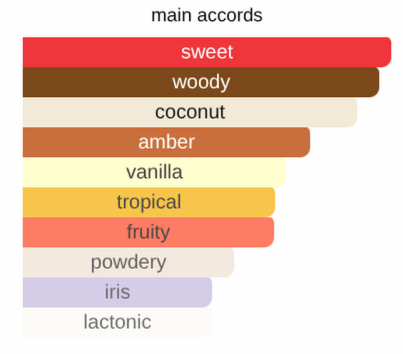

In [28]:
def obtain_accords(soup):
    accords_div_cell = soup.find_all('div', class_ = 'cell small-6 text-center')
    if accords_div_cell and len(accords_div_cell) >= 2:
        accords_div_tag = accords_div_cell[1].find('div', class_='grid-x')
        if accords_div_tag:
            accord_boxes = accords_div_tag.find_all('div', class_='cell accord-box')
            if accord_boxes:
                accords = []
                for accord_box in accord_boxes:
                    accord = accord_box.find('div', class_='accord-bar').get_text()
                    accords.append(accord)

                print('Accords: ')
                for acc in accords:
                    print(acc)
            else:
                accords = []
        else:
            accords = []
    else:
        accords = []

    return accords

### Dobavljanje nota

Funkcija `obtain_notes()` je zadužena za automatsko izdvajanje nota parfema sa stranice _fragrantica_. 
Note parfema predstavljaju pojedinačne mirisne sastojke koji se obično grupišu u tri kategorije: gornje (_Top Notes_), srednje (_Middle Notes_) i bazne note (_Base Notes_). Svaka od ovih grupa doprinosi različitim fazama razvoja mirisa na koži.

Funkcija prvo pronalazi deo stranice gde su note prikazane (`div` sa klasom `grid-x grid-padding-y`). Iz prvog pronađenog elementa, traži unutrašnji `div` sa klasom `cell`, u kojem se nalaze sve note. Zatim, izdvaja tekstualni sadržaj i deli ga na tri sekcije koristeći ključne reči "_Top Notes_", "_Middle Notes_" i "_Base Notes_".

Za svaku sekciju, funkcija uklanja suvišne razmake i formira rečnik sa tri ključa, gde su vrednosti liste nota za svaku grupu. Da bi se precizno razdvojile note, koristi se regularni izraz koji prepoznaje prelaz sa malog na veliko slovo, što označava početak nove note.

Na kraju, funkcija vraća rečnik sa listama nota za svaku grupu. Ako note nisu pronađene, vraća se prazna lista.

Primer kako su note prikazane na _fragrantica_ stranici:

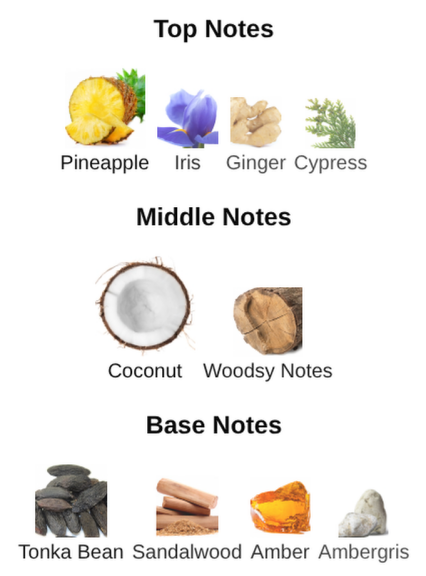

In [30]:
def obtain_notes(soup):
    notes_chart = soup.find_all('div', class_='grid-x grid-padding-y')
    if notes_chart:
        cell_div = notes_chart[0].find('div', class_='cell')
        if cell_div:
            div_list = cell_div.find_all('div')

            sections = re.split(r'Top Notes|Middle Notes|Base Notes', div_list[0].get_text())

            notes = {
                "Top Notes": sections[1].strip() if len(sections) > 1 else "",
                "Middle Notes": sections[2].strip() if len(sections) > 2 else "",
                "Base Notes": sections[3].strip() if len(sections) > 3 else ""
            }

            for key in notes:
                notes[key] = re.sub(r'([a-z])([A-Z])', r'\1| \2', notes[key]).split('| ')
                notes[key] = [note.strip() for note in notes[key] if note.strip()]

            print('Notes: ', notes)
        else:
            notes = []
    else:
        notes = []

    return notes

### Dobavljanje trajnosti (_longevity_) i intenziteta mirisa (_sillage_)

Funkcija `obtain_longevity_and_sillage()` služi za automatsko izdvajanje karakteristika trajnosti (_longevity_) i intenziteta mirisa (_sillage_) parfema sa stranice _fragrantica_. Ove dve karakteristike predstavljaju ključne parametre za procenu kvaliteta parfema iz perspektive korisnika.

_Longevity_ označava koliko dugo miris parfema ostaje na koži nakon nanošenja. Skala može biti: "_eternal_", "_long-lasting_", "_moderate_", "_weak_" i "_very weak_", sa odgovarajućim numeričkim vrednostima.
_Sillage_ predstavlja koliko se miris širi oko osobe koja nosi parfem, odnosno koliko je intenzivan. Skala može biti: "_enormous_", "_strong_", "_moderate_" i "_intimate_".
Funkcija pretražuje _HTML_ deo stranice gde su ove karakteristike prikazane (`div` sa klasom `cell small-12 medium-6`). Zatim prolazi kroz sve pronađene elemente i traži tekstualne oznake "_longevity_" i "_sillage_". Kada ih pronađe, izdvaja numeričku vrednost iz teksta koristeći jednostavnu podelu stringa.

Na kraju, funkcija vraća dve vrednosti: trajnost i intenzitet mirisa. Ako podaci nisu pronađeni, vraća prazne stringove.

Primer kako su trajnost (_longevity_) i intenzitet mirisa (_sillage_) prikazani na _fragrantica_ stranici:

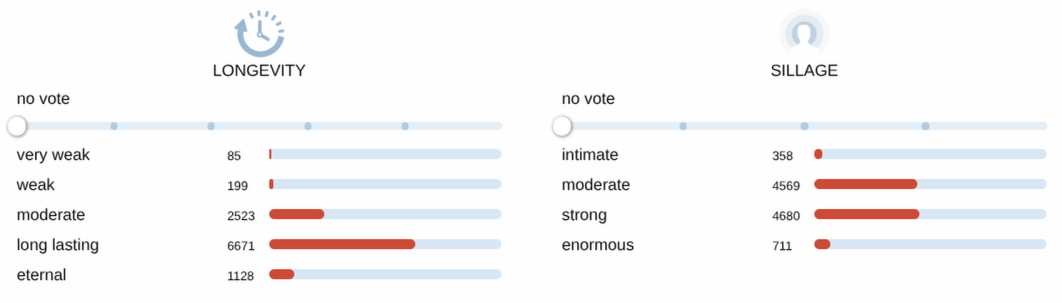

In [37]:
def obtain_longevity_and_sillage(soup):    
    bottom_voting_charts = soup.find_all('div', class_='cell small-12 medium-6')
    if bottom_voting_charts:
        for chart in bottom_voting_charts:
            if 'longevity' in chart.get_text():
                # longevity scale: eternal: 4.5 - 5.0, long-lasting: 4.0 - 4.49, moderate: 3.5 - 3.9, weak: 3.0 - 3.49, very weak: 0.0 - 2.99
                print(chart.get_text())
                longevity_number = chart.get_text().split(":")[1].split()[0]
                print(longevity_number)
            elif 'sillage' in chart.get_text():
                # sillage scale: enormous: 3.4 - 4.0, strong: 2.8 - 3.39, moderate: 2.2 - 2.79, intimate: 0.0 - 2.19
                print(chart.get_text())
                sillage_number = chart.get_text().split(":")[1].split()[0]
                print(sillage_number)
    else:
        longevity_number = ''
        sillage_number = ''

    return longevity_number, sillage_number

### Dobavljanje ocene i broja glasova

Funkcija `obtain_rating()` služi za automatsko izdvajanje prosečne ocene (rejtinga) parfema i broja glasova sa stranice _fragrantica_. Ove informacije predstavljaju korisničku percepciju kvaliteta parfema i mogu biti od velike važnosti za analizu i preporuku.

Funkcija pretražuje _HTML_ deo stranice gde je prikazana ocena parfema (`p` sa klasom `info-note`). Iz prvog pronađenog elementa izdvaja tekstualni sadržaj i koristi regularni izraz da pronađe numeričku vrednost ocene (od 0 do 5) i broj glasova koji su dali korisnici.

Ako su podaci uspešno pronađeni, funkcija ih smešta u rečnik sa dva ključa: '_rating_' (prosečna ocena) i '_votes_' (broj glasova). Ukoliko podaci nisu dostupni ili nisu prepoznati, funkcija vraća podrazumevane vrednosti 0 za oba ključa.

Primer kako su prosečna ocena i broj glasova prikazani na _fragrantica_ stranici:

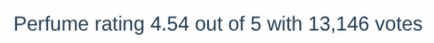

In [38]:
def obtain_rating(soup):
    rating = soup.find_all('p', class_='info-note')
    rating_dict = {}
    if rating:
        print(rating[0].get_text())
        match = re.search(r'rating\s+([\d.]+)\s+out of\s+5 with\s+([\d,]+)\s+votes', rating[0].get_text())

        if match:
            rating_dict['rating'] = float(match.group(1))
            rating_dict['votes'] = int(match.group(2).replace(',', ''))
        else:
            rating_dict['rating'] = 0
            rating_dict['votes'] = 0
    else:
        rating_dict['rating'] = 0
        rating_dict['votes'] = 0
    
    return rating_dict

### Dobavljanje opisa parfema

Funkcija `obtain_description()` služi za automatsko izdvajanje opisa parfema sa stranice _fragrantica_. Opis parfema daje korisnicima uvid u karakteristike, inspiraciju i mirisni profil parfema, često uključujući zanimljive detalje o njegovom nastanku.

Funkcija pretražuje _HTML_ deo stranice gde se nalazi opis (`div` sa atributom `itemprop="description"`). Ukoliko je opis pronađen, izdvaja tekstualni sadržaj i uklanja deo koji se odnosi na dodatne jezike ("_Read about this perfume in other languages_"), kako bi ostao samo relevantan opis na srpskom ili engleskom jeziku.

Ukoliko opis nije pronađen, funkcija vraća podrazumevanu poruku "_No description provided_".

Primer kako je opis parfema prikazan za _fragrantica_ stranici:

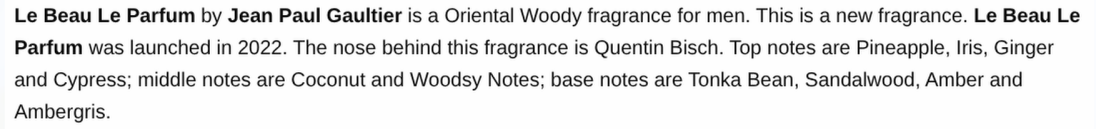

In [39]:
def obtain_description(soup):
    description = soup.find_all('div', {"itemprop": "description"})
    if description:
        stripped_description = description[0].get_text().split('Read about this perfume in other languages')[0]
        print(stripped_description)
    else:
        stripped_description = 'No description provided'

    return stripped_description

### Dobavljanje dizajnera (parfimera)

Funkcija `obtain_perfumers()` služi za automatsko izdvajanje imena dizajnera (parfimera) koji su kreirali određeni parfem sa stranice _fragrantica_. Parfimeri su često poznate ličnosti u svetu mirisa, a njihova imena mogu biti važna za ljubitelje parfema i analizu trendova.

Funkcija pretražuje _HTML_ deo stranice gde su dizajneri prikazani (`div` sa klasama `grid-x grid-padding-x grid-padding-y small-up-2 medium-up-2`). Ukoliko je taj deo pronađen, izdvaja sva imena dizajnera iz linkova (`a` tagova) i smešta ih u listu. Na taj način, funkcija omogućava da se zabeleže svi dizajneri koji su učestvovali u kreiranju parfema, bez obzira na njihov broj.

Ukoliko dizajneri nisu pronađeni, funkcija vraća listu sa vrednošću '_None_'.

Primer kako su dizajneri (parfimeri) prikazani na _fragrantica_ stranici:

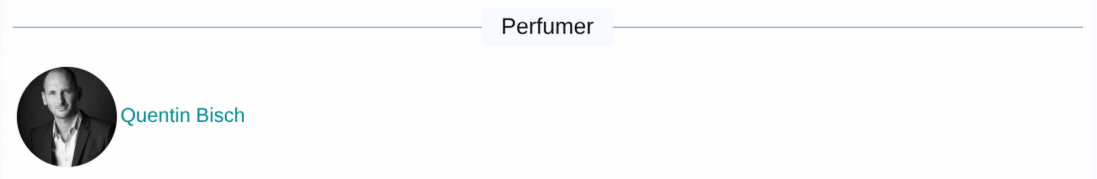

In [34]:
def obtain_perfumers(soup):    
    perfumers_div = soup.find('div', class_='grid-x grid-padding-x grid-padding-y small-up-2 medium-up-2')
    if perfumers_div:
        perfumer_names = perfumers_div.find_all('a')
        perfumers = []
        for perfumer in perfumer_names:
            print(perfumer.get_text())
            perfumers.append(perfumer.get_text())
    else:
        perfumers = ['None']

    return perfumers

### Dobavljanje informacija o preporučenim godišnjim dobima i delovima dana za nošenje parfema

Funkcija `obtain_season_and_day_ratings()` služi za automatsko izdvajanje informacija o preporučenim godišnjim dobima i delovima dana za nošenje parfema sa stranice _fragrantica_. Ove informacije predstavljaju kolektivnu percepciju korisnika o tome kada je parfem najprikladniji za upotrebu, što je izuzetno važno za personalizovane preporuke.

Funkcija koristi _Selenium WebDriver_ i _BeautifulSoup_ da bi parsirala dinamički generisan _HTML_ sadržaj stranice parfema.
Prvo pronalazi glavni deo stranice (`div` sa klasom `grid-x bg-white grid-padding-x grid-padding-y`) gde su prikazane ocene za sezone i delove dana.
Zatim izdvaja sve podsekcije (`div` sa klasom `cell small-12`) i iz drugog pronađenog elementa traži `grid` sa ocenjivanjem (`div` sa klasom `grid-x grid-margin-x grid-margin-y`).
Iz četvrtog grid elementa izdvaja sve grafičke prikaze ocena (`div` sa klasom `voting-small-chart-size`).

Definiše se lista oznaka: ['_winter_', '_spring_', '_summer_', '_fall_', '_day_', '_night_'], koja odgovara redosledu prikazanih ocena na sajtu.
Za svaku od ovih kategorija, funkcija izdvaja vrednost širine (`width`) iz _CSS_ stila, što predstavlja relativnu učestalost/preporuku za tu sezonu ili deo dana.
Vrednosti se prikupljaju u listu `season_values`, a zatim se dodeljuju promenljivama za svaku sezonu i deo dana.

Funkcija vraća dve string vrednosti:
`season_ratings`: formatiran prikaz preporuka za zimu, proleće, leto i jesen (npr. "_Winter: 40%_, _Spring: 30%_, _Summer: 20%_, _Fall: 10%_").
`day_ratings`: formatiran prikaz preporuka za dan i noć (npr. "_Day: 60%_, _Night: 40%_").
Ako podaci nisu dostupni ili nisu pronađeni, funkcija vraća podrazumevanu poruku "_No rating provided_" za obe kategorije.

Ova funkcija omogućava da se za svaki parfem precizno zabeleži kada ga korisnici najčešće preporučuju da se nosi. 

Primer kako su ove vrednosti prikazane na _fragrantica_ stranici:

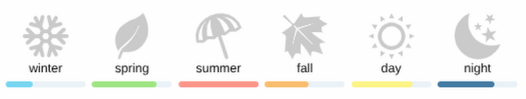

In [45]:
def obtain_season_and_day_ratings(driver, selenium_soup):
    parent_div = selenium_soup.find('div', class_='grid-x bg-white grid-padding-x grid-padding-y')
    if parent_div:
        parent_divs = parent_div.find_all('div', class_='cell small-12')
        if parent_divs and len(parent_divs) >= 2:
            child_grid_divs = parent_divs[1].find_all('div', class_='grid-x grid-margin-x grid-margin-y')
            if child_grid_divs and len(child_grid_divs) >= 4:
                seasons_div = child_grid_divs[3].find_all('div', class_='voting-small-chart-size')
                if seasons_div:
                    season_labels = ['winter', 'spring', 'summer', 'fall', 'day', 'night']
                    season_values = []

                    for i, season in enumerate(seasons_div[5:]):
                        child_season = season.find('div').find('div')

                        style = child_season.get('style')

                        for attr in style.split(';'):
                            if 'width' in attr:
                                width = attr.split(':')[1].strip()
                                print(f"{season_labels[i]} width: {width}")
                                season_values.append(width)

                    winter = season_values[0]
                    spring = season_values[1]
                    summer = season_values[2]
                    fall = season_values[3]
                    day = season_values[4]
                    night = season_values[5]

                    print(f"Winter: {winter}, Spring: {spring}, Summer: {summer}, Fall: {fall}, Day: {day}, Night: {night}")

                    season_ratings = f"Winter: {winter}, Spring: {spring}, Summer: {summer}, Fall: {fall}"
                    day_ratings = f"Day: {day}, Night: {night}"
                else:
                    season_ratings, day_ratings = 'No rating provided'
            else:
                season_ratings, day_ratings = 'No rating provided'
        else:
            season_ratings, day_ratings = 'No rating provided'
    else:
        season_ratings, day_ratings = 'No rating provided'

    return season_ratings, day_ratings

### Pokretanje _scraping_-a

Prvo se otvara fajl `togetherUniqueWithUrl.csv` koji sadrži podatke poput brenda, naziva parfema, _URL_-a slike i _URL_-a tog parfema na _fragrantica_ sajtu.

Potom se kreira novi fajl `fragranticaTemp.csv` u koji će se upisivati prošireni podaci o svakom parfemu. Prvi red sadrži nazive svih atributa koji se prikupljaju (brend, naziv, akordi, note, pol, trajnost, intenzitet, ocena, preporučene sezone i deo dana, dizajneri, opis, URL slike).

Skripta prolazi kroz svaki red ulaznog CSV fajla.Na svakih 5 parfema pravi pauzu od 6 minuta (`time.sleep(360)`) kako bi se izbeglo blokiranje od strane sajta zbog previše zahteva u kratkom vremenskom periodu.

Poziva funkciju `scrape_fragrance_info()` koja automatski prikuplja sve potrebne podatke sa Fragrantica stranice i upisuje ih u izlazni CSV fajl.

In [ ]:
print('Scraping fragrance information from fragrantica...')

with open('../datasets/togetherUniqueWithUrl.csv', 'r', encoding='utf-8') as fragrance_file:
    csv_reader = csv.reader(fragrance_file)
    next(csv_reader)
    with open('fragranticaTemp.csv', 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile, delimiter='|')

        csv_writer.writerow(['Brand', 'Name', 'Accords', 'Notes', 'Gender', 'Longevity', 'Sillage', 'Rating', 'Season ratings', 'Day ratings', 'Designers', 'Description', 'Image URL'])

        timeout_counter = 1
        for row in csv_reader:
            timeout_counter += 1
            if timeout_counter % 5 == 0:
                time.sleep(360) # ceka sest minuta
            brand, name, image_url, fragrantica_url = row
            print(f'Scraping {brand} - {name} from {fragrantica_url}...')
            scrape_fragrance_info(csv_writer, brand, name, image_url, fragrantica_url)

print('Done scraping fragrance info from fragrantica!')

Primer jednog reda iz _CSV_ fajla: